<a href="https://colab.research.google.com/github/KazGet/Summer_prac/blob/main/Summer_practies_3_1_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install missforest
from missforest import MissForest
!pip install optuna
import optuna
import shap
!pip install boruta
from boruta import BorutaPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.8 MB/s eta 0:00:00


In [220]:
file = "/content/3_task.xlsx"
df = pd.read_excel(file, sheet_name=1)
#Предсказание попадания пациента в группу 3 по клиническим данным — графы G-K, O-AD, AL-AR, AX-BJ, CJ, CK.
cols_to_peak = ['Age',	'Sex', 'Height', 'Weight', 'Body mass index', "LBBB", "AF", "Hypertension",	"Diabetes", "Smoker",	"Obesity",	"Dyslipidemia", "COPD", "Prior MI",
                "CABG",	"PCI past", "Peripheral artery disease",	"Carotid artery disease", "Cholesterol",	"LPLD_Ch",	"LPHD_Ch",	"Trigliceride",	"Creatinine",	"Creatinine clearance",
                "Glukosa", "Therapy: beta-blocker",	'Therapy: calcium antagonist',	'Therapy: nitrate',	'Therapy: statin',	"Therapy: diuretic",	"Therapy: aspirin",	"Therapy: other antiplatelet agent",
                'Therapy: anticoagulant',	'Therapy anti diabetic drugs',	'Therapy insulin',	'Therapy: ACE-I',	'Therapy: sartan',	"Therapy: aldosterone-antagonist", "ESC Pre-test Probability",
                "NYHA Class", 'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +']
df=df[cols_to_peak]
df = df.rename(columns={'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +': 'Phenotype_angio'})

rbbb_mask = df['LBBB'] == 'RBBB'
df['RBBB'] = rbbb_mask.astype(int)
df['LBBB'] = df['LBBB'].replace({'RBBB': np.nan})

categorical_features = ["LBBB", "Smoker", "Therapy anti diabetic drugs", 'ESC Pre-test Probability']
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

df['target'] = (df['Phenotype_angio'] == 3).astype(int)
df.drop(['Phenotype_angio'], axis=1, inplace=True)
X = df.drop('target', axis=1)
y = df['target']


/tmp/ipython-input-220-3859827495.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LBBB'] = df['LBBB'].replace({'RBBB': np.nan})


In [4]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.3].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('target', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [5]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=15)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [6]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=25, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [01:02<00:00, 12.52s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

In [ ]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]

# Визуализируем нагрузки для первых 10 компонент
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
plt.show()

In [10]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 9
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))

Отобранные признаки для данных, заполенными медианой: 
['Age', 'Height', 'Weight', 'Body mass index', 'Cholesterol', 'LPHD_Ch', 'Trigliceride', 'Creatinine clearance', 'Glukosa']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['Height', 'Body mass index', 'Cholesterol', 'LPHD_Ch', 'Trigliceride', 'Creatinine', 'Creatinine clearance', 'Glukosa', 'ESC Pre-test Probability']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['Age', 'Weight', 'Cholesterol', 'LPHD_Ch', 'Trigliceride', 'Creatinine', 'Creatinine clearance', 'Glukosa', 'ESC Pre-test Probability']
Отобранные признаки для данных, заполенными методом MissForest: 
['Height', 'Body mass index', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Therapy: anticoagulant', 'Therapy anti diabetic drugs', 'Therapy: ACE-I', 'Therapy: sartan', 'NYHA Class']

Пересечение всех признаков: 
set()


In [11]:
print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))


Пересечение всех признаков: 
{'Cholesterol', 'Glukosa', 'Creatinine clearance', 'LPHD_Ch', 'Trigliceride'}


In [172]:
# @title Отбор признаков методом Boruta
dfrf = df_MICE
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=200,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['LPHD_Ch', 'ESC Pre-test Probability']


In [13]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy', n_jobs=-1)
selector.fit(df_test, y)
selected_features = df_test.columns[selector.get_support()]
print("Оптимальное число признаков:", selector.n_features_)
print("Отобранные признаки:", selected_features.tolist())

Оптимальное число признаков: 39
Отобранные признаки: ['Age', 'Sex', 'Height', 'Weight', 'Body mass index', 'LBBB', 'AF', 'Hypertension', 'Diabetes', 'Smoker', 'Obesity', 'Dyslipidemia', 'COPD', 'Prior MI', 'CABG', 'PCI past', 'Peripheral artery disease', 'Carotid artery disease', 'Cholesterol', 'LPLD_Ch', 'LPHD_Ch', 'Trigliceride', 'Creatinine', 'Creatinine clearance', 'Glukosa', 'Therapy: beta-blocker', 'Therapy: calcium antagonist', 'Therapy: nitrate', 'Therapy: statin', 'Therapy: diuretic', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Therapy: anticoagulant', 'Therapy anti diabetic drugs', 'Therapy: ACE-I', 'Therapy: sartan', 'Therapy: aldosterone-antagonist', 'ESC Pre-test Probability', 'NYHA Class']


In [14]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")


print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))

Отобранные признаки с данными медианой:
['Dyslipidemia', 'Prior MI', 'Carotid artery disease', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'NYHA Class']
Отобранные признаки с данными KNN:
['Dyslipidemia', 'Prior MI', 'Carotid artery disease', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'ESC Pre-test Probability']
Отобранные признаки с данными MICE:
['Age', 'Sex', 'Dyslipidemia', 'Prior MI', 'CABG', 'Peripheral artery disease', 'Carotid artery disease', 'Glukosa', 'NYHA Class']
Отобранные признаки с данными MF:
['Prior MI', 'PCI past', 'Cholesterol', 'Trigliceride', 'Creatinine', 'Glukosa', 'Therapy: statin', 'Therapy: sartan', 'NYHA Class']

Пересечение всех результатов (медиана ∩ KNN ∩ MICE):
['Carotid artery disease', 'Dyslipidemia', 'Prior MI']


In [15]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    # Стандартизация + подбор alpha через кросс-валидацию
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    # Финальная модель с выбранным alpha
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    # Отбор ненулевых коэффициентов
    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

# Прогоним для всех способов заполнения
features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

# Пересечение всех
print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0076

Выбранные признаки для Median:
 ['Age', 'Sex', 'Weight', 'Body mass index', 'LBBB', 'Hypertension', 'Obesity', 'Dyslipidemia', 'COPD', 'Prior MI', 'CABG', 'PCI past', 'Peripheral artery disease', 'Carotid artery disease', 'LPLD_Ch', 'LPHD_Ch', 'Trigliceride', 'Creatinine clearance', 'Glukosa', 'Therapy: beta-blocker', 'Therapy: nitrate', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Therapy: anticoagulant', 'Therapy anti diabetic drugs', 'Therapy insulin', 'Therapy: ACE-I', 'Therapy: aldosterone-antagonist', 'NYHA Class']

KNN: наилучшее значение alpha = 0.0105

Выбранные признаки для KNN:
 ['Weight', 'LBBB', 'Hypertension', 'Obesity', 'Dyslipidemia', 'COPD', 'Prior MI', 'CABG', 'PCI past', 'Peripheral artery disease', 'Carotid artery disease', 'LPHD_Ch', 'Creatinine clearance', 'Glukosa', 'Therapy: beta-blocker', 'Therapy: nitrate', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Th

In [16]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('target', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=10, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:48<00:00,  9.67s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['Age', 'Height', 'Body mass index', 'Cholesterol', 'LPHD_Ch', 'Trigliceride', 'Creatinine', 'Creatinine clearance', 'Glukosa']
Отобранные признаки методом RFE+MF: 
['Age', 'Height', 'Body mass index', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Therapy: anticoagulant', 'Therapy anti diabetic drugs', 'Therapy: ACE-I', 'Therapy: sartan']

Отобранные признаки методом ANOVA:
 ['Sex', 'Dyslipidemia', 'Prior MI', 'CABG', 'Peripheral artery disease', 'Carotid artery disease', 'LPHD_Ch', 'Therapy: aspirin', 'NYHA Class']
Общие признаки в RFE и ANOVA: {'LPHD_Ch'}

Отобранные признаки методом ANOVA (MF):
 ['Prior MI', 'PCI past', 'Cholesterol', 'Trigliceride', 'Creatinine', 'Glukosa', 'Therapy: statin', 'Therapy: diuretic', 'Therapy: sartan']
Общие признаки в RFE и ANOVA: {'Therapy: sartan'}


In [17]:
print(set(selected_features_MF) & set(selected_featuresMF) & set(selected_features_MICE) & set(selected_featuresMICE))

set()


Accuracy: 0.7362637362637363
Recall: 0.8620689655172413

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.68      0.78        62
           1       0.56      0.86      0.68        29

    accuracy                           0.74        91
   macro avg       0.73      0.77      0.73        91
weighted avg       0.80      0.74      0.75        91


Confusion matrix:
 [[42 20]
 [ 4 25]]
ROC AUC (Train): 0.8096118944576295
ROC AUC: 0.7541713014460513


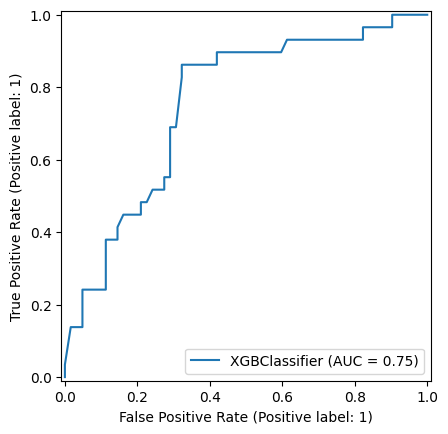

<Figure size 2000x1200 with 0 Axes>

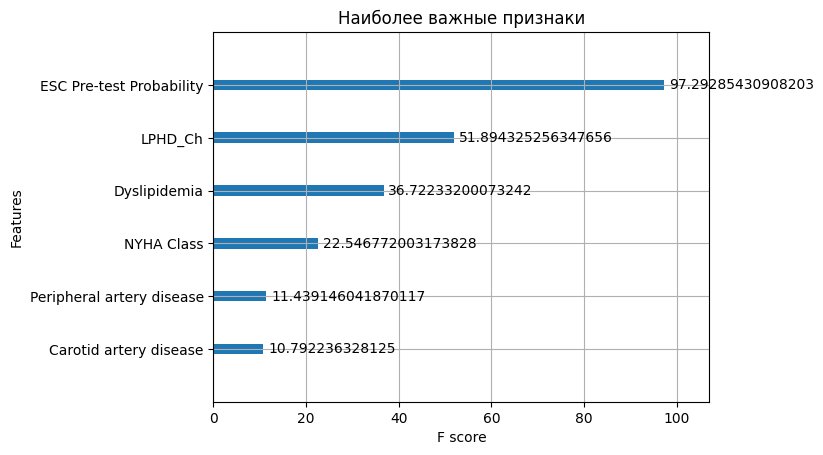

In [304]:
# @title XGBoost

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

optimal_cols =  ['Dyslipidemia', 'LPHD_Ch', 'ESC Pre-test Probability', 'NYHA Class','Carotid artery disease', 'Peripheral artery disease', 'PCI past']
X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)
neg = len(y_train[y_train == 0])  # или sum(y_train == 0)
pos = len(y_train[y_train == 1])  # или sum(y_train == 1)
scale_pos_weight = neg / pos

params = {'max_depth': 6, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632,
          'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': scale_pos_weight}

model = XGBClassifier(**params, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

plt.figure(figsize=(20, 12))
plot_importance(model, max_num_features=len(optimal_cols), importance_type='total_gain')
plt.title("Наиболее важные признаки")
plt.show()

0:	learn: 0.6050420	total: 325us	remaining: 37.4ms
25:	learn: 0.7899160	total: 5.07ms	remaining: 17.5ms
50:	learn: 0.7142857	total: 9.67ms	remaining: 12.3ms
75:	learn: 0.7142857	total: 14.2ms	remaining: 7.49ms
100:	learn: 0.7310924	total: 19.1ms	remaining: 2.83ms
115:	learn: 0.7647059	total: 21.9ms	remaining: 0us
Accuracy: 0.7472527472527473
Recall: 0.7692307692307693

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81        65
           1       0.54      0.77      0.63        26

    accuracy                           0.75        91
   macro avg       0.71      0.75      0.72        91
weighted avg       0.79      0.75      0.76        91


Confusion matrix:
 [[48 17]
 [ 6 20]]
ROC AUC (Train): 0.8479129356660697
ROC AUC: 0.765680473372781


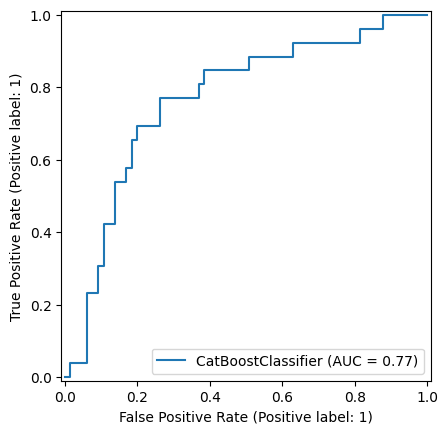

ESC Pre-test Probability: 25.7095
LPHD_Ch: 16.8553
Therapy: other antiplatelet agent: 14.8633
Dyslipidemia: 13.1525
Carotid artery disease: 9.3906
Therapy: beta-blocker: 9.1200
Prior MI: 8.2853
CABG: 2.6235


In [302]:
# @title CatBoostClassifier
# optimal_cols =  ['Dyslipidemia','LPHD_Ch','ESC Pre-test Probability', 'NYHA Class', 'Creatinine' ,'Glukosa','AF','Carotid artery disease' ]

# optimal_cols =  ['LPHD_Ch', 'Therapy: beta-blocker',  'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'PCI past','Prior MI',
#                  'Carotid artery disease','ESC Pre-test Probability',]

optimal_cols=['Dyslipidemia', 'Prior MI', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: other antiplatelet agent','Carotid artery disease',
              'ESC Pre-test Probability', 'CABG',]

"""
['Dyslipidemia', 'Prior MI', 'Carotid artery disease', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'NYHA Class']
['Prior MI', 'CABG', 'Carotid artery disease', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: statin', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'ESC Pre-test Probability']
['Age', 'Sex', 'Dyslipidemia', 'Prior MI', 'CABG', 'Peripheral artery disease', 'Carotid artery disease', 'LPHD_Ch', 'NYHA Class']
['Prior MI', 'PCI past', 'Cholesterol', 'Trigliceride', 'Creatinine', 'Glukosa', 'Therapy: statin', 'Therapy: sartan', 'NYHA Class']
['LPHD_Ch', 'Carotid artery disease', 'Prior MI']
"""
X_boost = X[optimal_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X_boost, y,
    test_size=0.2,
    random_state=0,
    shuffle=True
)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

params =  {'iterations': 116, 'learning_rate': 0.10155568960633561, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 8.373440044547419,
           'bagging_temperature': 0.5976094384513785, 'border_count': 203, 'scale_pos_weight': scale_pos_weight, "loss_function": "Logloss", "eval_metric": "Recall", "verbose":25}

model = CatBoostClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()


importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Вывод важности признаков
for i in range(len(X_boost.columns)):
    print(f"{X_boost.columns[indices[i]]}: {importances[indices[i]]:.4f}")

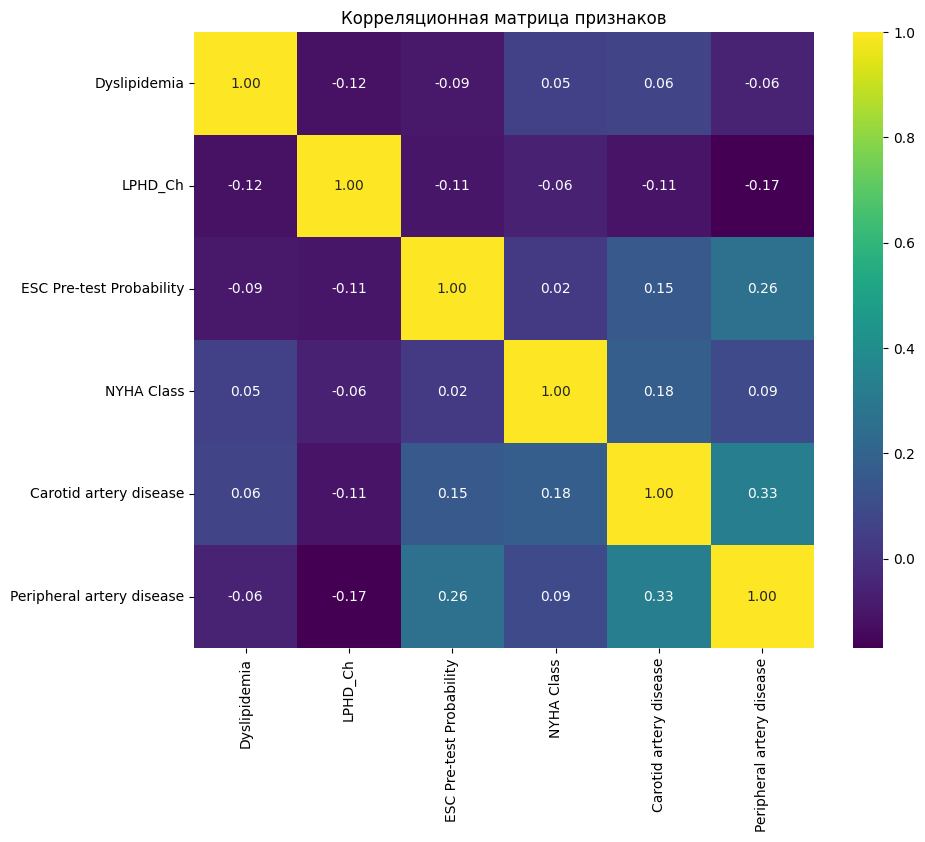

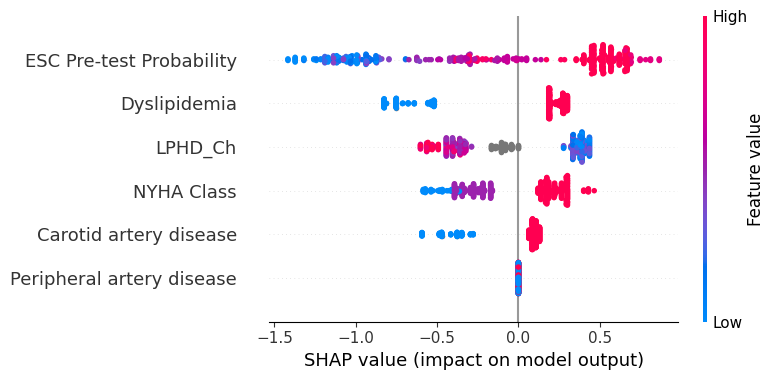

In [292]:
  # @title Матрица корреляции для отобранных признаков; SHAP
corr_matrix = X_boost.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")

plt.title('Корреляционная матрица признаков')
plt.show()
print()

# Специализированный explainer для деревьев
explainer = shap.TreeExplainer(model)

# SHAP значения для признаков
shap_values = explainer.shap_values(X_boost)

# График важности признаков
shap.summary_plot(shap_values, X_boost)

In [ ]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Веса главных компонент по всем признакам
data=df_MICE[optimal_cols]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

for i in range(1, len(X_boost.columns)):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

# print(new_X)
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

[I 2025-07-12 11:16:37,533] A new study created in memory with name: no-name-5703efbc-ff73-4b6d-8ef5-680a130732f7
[I 2025-07-12 11:16:37,674] Trial 0 finished with value: 0.7284396141432191 and parameters: {'max_depth': 4, 'learning_rate': 0.2502958108809578, 'n_estimators': 169, 'min_child_weight': 11, 'gamma': 0.19573721310915881, 'subsample': 0.8114345999387168, 'colsample_bytree': 0.7062997694107274, 'reg_alpha': 2.574946248116396, 'reg_lambda': 1.7804468340396271, 'scale_pos_weight': 1.7902979022482448}. Best is trial 0 with value: 0.7284396141432191.
[I 2025-07-12 11:16:37,815] Trial 1 finished with value: 0.7338080563102901 and parameters: {'max_depth': 5, 'learning_rate': 0.10917417784743581, 'n_estimators': 168, 'min_child_weight': 12, 'gamma': 0.645537442939949, 'subsample': 0.6641199487059185, 'colsample_bytree': 0.8546440408500832, 'reg_alpha': 0.6210723847011946, 'reg_lambda': 6.17740250762861, 'scale_pos_weight': 2.1763766084143565}. Best is trial 1 with value: 0.73380805

Best trial:
AUC: 0.7581274275606775
Params: {'max_depth': 6, 'learning_rate': 0.2886783401090138, 'n_estimators': 284, 'min_child_weight': 20, 'gamma': 0.3383978932510041, 'subsample': 0.7086813386116358, 'colsample_bytree': 0.6278359994367403, 'reg_alpha': 0.11147282697904211, 'reg_lambda': 1.2408306047220816, 'scale_pos_weight': 2.108671800392105}
Accuracy: 0.6373626373626373
Recall: 0.6551724137931034

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.63      0.70        62
           1       0.45      0.66      0.54        29

    accuracy                           0.64        91
   macro avg       0.62      0.64      0.62        91
weighted avg       0.69      0.64      0.65        91


Confusion matrix:
 [[39 23]
 [10 19]]
ROC AUC (Train): 0.8568511796733213
ROC AUC: 0.7052280311457174


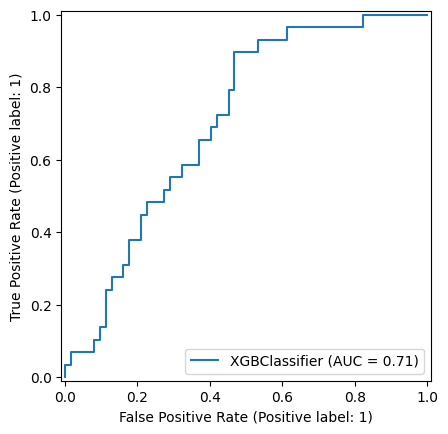

In [307]:
# @title Optuna для XGBoostClassifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.4, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True), # Усилили L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True), # Усилили L2

        # 2. Позволяем Optuna найти лучший баланс
        # Соотношение 62/29 ≈ 2.14. Ищем вокруг этого значения.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.5, 3.0),

        # Стандартные параметры
        'use_label_encoder': False,
        'eval_metric': 'logloss' # logloss лучше подходит для оптимизации вероятностей
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)


print("Best trial:")
print("AUC:", study.best_value)
print("Params:", study.best_params)


best_params = study.best_params
best_params['eval_metric'] = 'auc' #не влияет на обучение
model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [ ]:
# @title Optuna для CatBoostClassifier
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 3.0),
        "verbose": False,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "early_stopping_rounds": 50
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_boost, y, cv=cv, scoring="roc_auc")
    return np.mean(auc_scores)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оценка
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()